# Ames Housing Dataset

## About Dataset
The Ames Housing Dataset is a well-known dataset in the field of machine learning and data analysis. It contains various features and attributes of residential homes in Ames, Iowa, USA. The dataset is often used for regression tasks, particularly for predicting housing prices.

### Key Details:
- **Number of Instances**: The dataset consists of 2,930 instances or observations.
- **Number of Features**: There are 79 different features or variables that describe various aspects of the residential properties.
- **Target Variable**: The target variable in the dataset is `SalePrice`, representing the sale price of the houses.
- **Data Types**:  
  - The features include both numerical and categorical variables.
  - They cover a wide range of aspects such as lot size, number of rooms, location, construction quality, and more.

### Applications:
The Ames Housing Dataset is widely used in the machine learning community for:
- **Regression Modeling**: Predicting house prices based on property features.
- **Feature Engineering**: Developing and testing new techniques to handle numerical and categorical data.
- **Predictive Analytics**: Analyzing and forecasting trends in the real estate domain.

This dataset serves as a valuable resource for exploring and applying machine learning algorithms to real-world problems related to housing prices.


# STEP 1: IMPORT LIBRARIES AND SETUP

In [1]:
import os

# Data Handling & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Functions
from scipy.stats import skew

# Scikit-learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, PolynomialFeatures

# AWS & SageMaker Libraries
import boto3
import sagemaker
from sagemaker import Session, get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.amazon.linear_learner import LinearLearner
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# File Path and Original Target Column
file_path = "AmesHousing.csv"
original_target_col = "SalePrice"

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[01/29/25 13:06:06] INFO     Found credentials from IAM Role:                                   ]8;id=789510;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=529572;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# STEP 2: LOAD THE DATA

In [2]:
# STEP 2: LOAD THE DATA
def load_data(filepath):
    """
    Load the CSV file into a pandas DataFrame.
    """
    df = pd.read_csv(filepath)
    return df

df = load_data(file_path)

print("Data Loaded Successfully!\n")
print(df.head())
print("\nShape of the dataset:", df.shape)
df.info()


Data Loaded Successfully!

   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Cond

# STEP 3: PREPROCESS THE DATA

## 3.1 Drop Columns with Too Many Missing Values

In [3]:
def drop_high_missing_columns(dataframe, threshold=0.3):
    """
    Drop columns that have a fraction of missing values above the given threshold.
    """
    missing_fraction = dataframe.isnull().mean()
    cols_to_drop = missing_fraction[missing_fraction > threshold].index
    print(f"Columns to drop (>{threshold*100}% missing):", list(cols_to_drop))
    dataframe.drop(columns=cols_to_drop, inplace=True)
    return dataframe

df = drop_high_missing_columns(df, threshold=0.3)

Columns to drop (>30.0% missing): ['Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']


## 3.2 Drop Rows with Missing Target

In [4]:
def drop_missing_target(dataframe, target_column):
    """
    Drop rows that have missing values in the target column.
    """
    if target_column not in dataframe.columns:
        print(f"Target column '{target_column}' not found. Skipping.")
        return dataframe
    
    before = len(dataframe)
    dataframe.dropna(subset=[target_column], inplace=True)
    after = len(dataframe)
    print(f"Dropped {before - after} rows that had missing {target_column}.")
    return dataframe

df = drop_missing_target(df, original_target_col)

Dropped 0 rows that had missing SalePrice.


## 3.3 Fill Remaining Missing Values

In [5]:
def fill_missing_values(dataframe):
    """
    Fill missing numeric values with the median 
    and fill missing categorical values with 'Missing'.
    """
    numeric_cols = dataframe.select_dtypes(include=[np.number]).columns
    categorical_cols = dataframe.select_dtypes(exclude=[np.number]).columns

    for col in numeric_cols:
        if dataframe[col].isnull().any():
            dataframe[col].fillna(dataframe[col].median(), inplace=True)

    for col in categorical_cols:
        if dataframe[col].isnull().any():
            dataframe[col].fillna("Missing", inplace=True)

    return dataframe

df = fill_missing_values(df)


## 3.4 Remove Outliers

In [6]:
def remove_outliers(dataframe, col_name="Gr Liv Area", upper_limit=4000):
    """
    Remove rows where the specified column exceeds the upper limit.
    """
    if col_name not in dataframe.columns:
        print(f"Column '{col_name}' not found. Skipping outlier removal.")
        return dataframe
    
    before = len(dataframe)
    dataframe = dataframe[dataframe[col_name] < upper_limit]
    after = len(dataframe)
    print(f"Removed {before - after} outliers from '{col_name}'.")
    return dataframe

df = remove_outliers(df, col_name="Gr Liv Area", upper_limit=4000)

Removed 5 outliers from 'Gr Liv Area'.


## 3.5 Encode Categorical Variables

In [7]:
def encode_categorical_features(dataframe, freq_threshold=10):
    """
    Encode categorical features using:
      - Frequency encoding if # of categories > freq_threshold
      - One-hot encoding if # of categories <= freq_threshold
    """
    cat_cols = dataframe.select_dtypes(include=["object"]).columns
    one_hot_frames = []
    freq_frames = {}

    for col in cat_cols:
        unique_count = dataframe[col].nunique()
        
        if unique_count > freq_threshold:
            # Frequency encoding
            freq_map = dataframe[col].value_counts(normalize=True)
            freq_frames[col + "_freq"] = dataframe[col].map(freq_map)
        else:
            # One-hot encoding
            dummies = pd.get_dummies(dataframe[col], prefix=col, drop_first=True)
            one_hot_frames.append(dummies)

    # Combine frequency-encoded columns
    if freq_frames:
        freq_df = pd.DataFrame(freq_frames, index=dataframe.index)
        dataframe = pd.concat([dataframe, freq_df], axis=1)

    # Combine one-hot encoded columns
    if one_hot_frames:
        ohe_df = pd.concat(one_hot_frames, axis=1)
        dataframe = pd.concat([dataframe, ohe_df], axis=1)

    # Drop original categorical columns
    dataframe.drop(columns=cat_cols, inplace=True)
    return dataframe

df = encode_categorical_features(df, freq_threshold=10)

# STEP 4: CREATE A BINARY TARGET

In [8]:
median_price = df[original_target_col].median()
df["AboveMedianPrice"] = (df[original_target_col] > median_price).astype(int)

# Drop the original SalePrice column now that we have a binary target
df.drop(columns=[original_target_col], inplace=True)

print(df["AboveMedianPrice"].head())

0    1
1    0
2    1
3    1
4    1
Name: AboveMedianPrice, dtype: int64


# STEP 5: SPLIT DATA 

In [9]:
X = df.drop("AboveMedianPrice", axis=1)
y = df["AboveMedianPrice"]

# Split into Train and Validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Shapes after splitting:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)

Shapes after splitting:
X_train: (2340, 203) y_train: (2340,)
X_val: (585, 203) y_val: (585,)


# STEP 6: SET UP SAGEMAKER SESSION AND ROLE

In [10]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/ames-housing-binary"
region = sagemaker_session.boto_region_name

print(f"Role: {role}")
print(f"Region: {region}")
print(f"Bucket: {bucket}")

[01/29/25 13:06:07] INFO     Found credentials from IAM Role:                                   ]8;id=910038;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=616292;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[01/29/25 13:06:08] INFO     Found credentials from IAM Role:                                   ]8;id=425590;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=385831;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Role: arn:aws:iam::525897591902:role/LabRole
Region: us-east-1
Bucket: sagemaker-us-east-1-525897591902


# STEP 7: PREPARE TRAINING AND VALIDATION DATA (UPLOAD TO S3)

In [11]:
# Combine labels and features so the target is in the first column (SageMaker format)
train_data = pd.concat([y_train, X_train], axis=1)
validation_data = pd.concat([y_val, X_val], axis=1)

train_file = "ames_train.csv"
validation_file = "ames_validation.csv"

# Save locally (no header, target in first column)
train_data.to_csv(train_file, index=False, header=False)
validation_data.to_csv(validation_file, index=False, header=False)

print(f"Training data saved to {train_file}")
print(f"Validation data saved to {validation_file}")
print("Final DataFrame shape (after all preprocessing):", df.shape)

# Upload to S3
train_uri = sagemaker_session.upload_data(path=train_file, bucket=bucket, key_prefix=prefix)
validation_uri = sagemaker_session.upload_data(path=validation_file, bucket=bucket, key_prefix=prefix)

print(f"Training Data URI: {train_uri}")
print(f"Validation Data URI: {validation_uri}")


Training data saved to ames_train.csv
Validation data saved to ames_validation.csv
Final DataFrame shape (after all preprocessing): (2925, 204)
Training Data URI: s3://sagemaker-us-east-1-525897591902/sagemaker/ames-housing-binary/ames_train.csv
Validation Data URI: s3://sagemaker-us-east-1-525897591902/sagemaker/ames-housing-binary/ames_validation.csv


# STEP 8: TRAIN THE LINEAR LEARNER MODEL (BINARY CLASSIFICATION)

In [12]:
# Retrieve the Linear Learner container
container = sagemaker.image_uris.retrieve(
    framework="linear-learner",
    region=region
)

# Create Estimator
linear_learner = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session
)

# Set hyperparameters for binary classification
num_features = X.shape[1]
linear_learner.set_hyperparameters(
    feature_dim=num_features,
    predictor_type='binary_classifier',
    mini_batch_size=32,
    epochs=10
)

train_input = TrainingInput(s3_data=train_uri, content_type="text/csv")
validation_input = TrainingInput(s3_data=validation_uri, content_type="text/csv")

# Train the model
linear_learner.fit({'train': train_input, 'validation': validation_input})
print("Model training complete!")

[01/29/25 13:06:09] INFO     Same images used for training and inference. Defaulting to image     ]8;id=664311;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=727632;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#391\391]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=219666;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=12664;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

                    INFO     Found credentials from IAM Role:                                   ]8;id=7127;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=846272;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=861536;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=358517;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=240652;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=908639;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             linear-learner-2025-01-29-13-06-09-912                                                

2025-01-29 13:06:11 Starting - Starting the training job...
2025-01-29 13:06:26 Starting - Preparing the instances for training...
2025-01-29 13:06:58 Downloading - Downloading input data...
2025-01-29 13:07:38 Downloading - Downloading the training image.........
2025-01-29 13:09:04 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/29/2025 13:09:09 INFO 139637732312896] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss':

# STEP 9: DEPLOY THE MODEL AND EVALUATE

Endpoint 'binary-linear-learner-endpoint' does not exist.
Endpoint config 'binary-linear-learner-endpoint-config' does not exist.


[01/29/25 13:11:24] INFO     Creating model with name: linear-learner-2025-01-29-13-11-24-788       ]8;id=501640;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=314790;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[01/29/25 13:11:25] INFO     Creating endpoint-config with name binary-linear-learner-endpoint      ]8;id=499539;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=345477;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\

                    INFO     Creating endpoint with name binary-linear-learner-endpoint             ]8;id=516275;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=398037;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

-------!Accuracy:  0.9368
Precision: 0.9406
Recall:    0.9308
F1 Score:  0.9357

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       296
           1       0.94      0.93      0.94       289

    accuracy                           0.94       585
   macro avg       0.94      0.94      0.94       585
weighted avg       0.94      0.94      0.94       585

Confusion Matrix (Raw Values):
[[279  17]
 [ 20 269]]


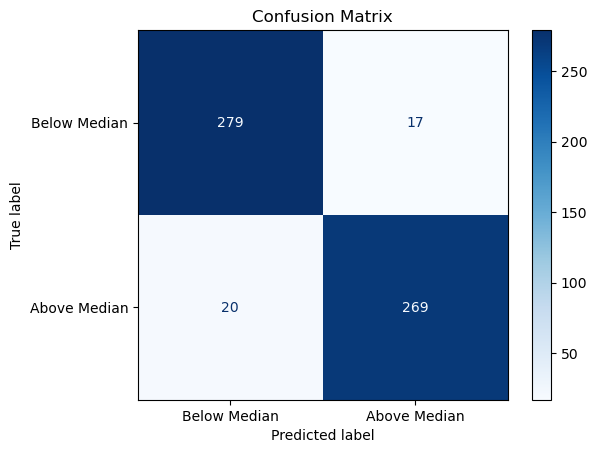

In [14]:
# Define endpoint details
endpoint_config_name = "binary-linear-learner-endpoint-config"
endpoint_name = "binary-linear-learner-endpoint"

session = Session()
sm_client = boto3.client("sagemaker")

# Helper functions to force-delete existing endpoints/configs
def force_delete_endpoint(ep_name):
    """
    If the endpoint exists, delete it without user prompt.
    """
    try:
        sm_client.describe_endpoint(EndpointName=ep_name)
        print(f"Deleting endpoint: {ep_name}")
        sm_client.delete_endpoint(EndpointName=ep_name)
        print(f"Deleted endpoint: {ep_name}")
    except sm_client.exceptions.ClientError as e:
        error_message = e.response["Error"]["Message"]
        if "Could not find endpoint" in error_message or "ResourceNotFoundException" in error_message:
            print(f"Endpoint '{ep_name}' does not exist.")
        else:
            raise e

def force_delete_endpoint_config(ep_config_name):
    """
    If the endpoint config exists, delete it without user prompt.
    """
    try:
        sm_client.describe_endpoint_config(EndpointConfigName=ep_config_name)
        print(f"Deleting endpoint config: {ep_config_name}")
        sm_client.delete_endpoint_config(EndpointConfigName=ep_config_name)
        print(f"Deleted endpoint config: {ep_config_name}")
    except sm_client.exceptions.ClientError as e:
        error_message = e.response["Error"]["Message"]
        if "Could not find endpoint configuration" in error_message or "ResourceNotFoundException" in error_message:
            print(f"Endpoint config '{ep_config_name}' does not exist.")
        else:
            raise e

# Clean up any existing endpoint/config with the same names
force_delete_endpoint(endpoint_name)
force_delete_endpoint_config(endpoint_config_name)

# Deploy the model
predictor = linear_learner.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=endpoint_name
)

# Attach serializers/deserializers
predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()

# Evaluate on the validation set (used here as a test set)
X_test = X_val.copy()
y_test = y_val.copy()

# Get predictions
predictions = predictor.predict(X_test.values)

# Extract predicted probabilities
predicted_probs = [float(result["score"]) for result in predictions["predictions"]]
threshold = 0.5
predicted_labels = [1 if prob > threshold else 0 for prob in predicted_probs]

# Compute metrics
acc = accuracy_score(y_test, predicted_labels)
prec = precision_score(y_test, predicted_labels, zero_division=0)
rec = recall_score(y_test, predicted_labels, zero_division=0)
f1 = f1_score(y_test, predicted_labels, zero_division=0)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, predicted_labels))

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix (Raw Values):")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Below Median", "Above Median"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# STEP 10: QUERY THE DEPLOYED ENDPOINT WITH TEST DATA

In [15]:
# Pick the first 5 rows from the test set
sample_data = X_test.head(5)

# Convert sample data to a NumPy array
input_data = sample_data.values

# Get predictions from the endpoint
predictions = predictor.predict(input_data)

# Extract the predicted values (scores/probabilities) from the response
if "predictions" in predictions:
    y_pred_test_probs = [float(result["score"]) for result in predictions["predictions"]]
    
    # Convert probabilities to classes
    threshold = 0.5
    y_pred_test_classes = [1 if prob > threshold else 0 for prob in y_pred_test_probs]
    
    print("\nTest Probabilities on 5 samples:", y_pred_test_probs)
    print("Test Predicted Classes on 5 samples:", y_pred_test_classes)
else:
    print("No 'predictions' key found in the response:", predictions)

# Compare with actual values if you want
sample_targets = y_test.loc[sample_data.index]
print("Actual:", sample_targets.tolist())



Test Probabilities on 5 samples: [0.35961008071899414, 0.999995231628418, 0.989909291267395, 0.7596032023429871, 0.04945291951298714]
Test Predicted Classes on 5 samples: [0, 1, 1, 1, 0]
Actual: [0, 1, 1, 1, 0]


# STEP 11: DELETE THE ENDPOINT AND ENDPOINT CONFIG (OPTIONAL CLEANUP)

In [ ]:
def delete_sagemaker_endpoint_and_config(sm_client, endpoint_name, endpoint_config_name):
    """
    Delete a SageMaker endpoint and its configuration if they exist.
    """
    # Delete the endpoint
    try:
        sm_client.describe_endpoint(EndpointName=endpoint_name)
        sm_client.delete_endpoint(EndpointName=endpoint_name)
        print(f"Deleted endpoint: {endpoint_name}")
    except sm_client.exceptions.ClientError as e:
        if "Could not find endpoint" in str(e) or "ResourceNotFound" in str(e):
            print(f"Endpoint '{endpoint_name}' does not exist.")
        else:
            raise e

    # Delete the endpoint config
    try:
        sm_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f"Deleted endpoint config: {endpoint_config_name}")
    except sm_client.exceptions.ClientError as e:
        if "Could not find endpoint configuration" in str(e) or "ResourceNotFound" in str(e):
            print(f"Endpoint config '{endpoint_config_name}' does not exist.")
        else:
            raise e

# Uncomment to clean up once you're done testing:
# delete_sagemaker_endpoint_and_config(sm_client, Endpoint, EndpointConfig)